In [ ]:
import numpy
import pyreaper
import scipy
import statsmodels
import scipy.io.wavfile as wavfile

### 3.1 Создать звуковой файл формата .wav ✅

### 3.2 Оценка основного тона на основе АКФ

#### Step 1 

In [ ]:
def my_acf(x, m):
    


#### Step 2
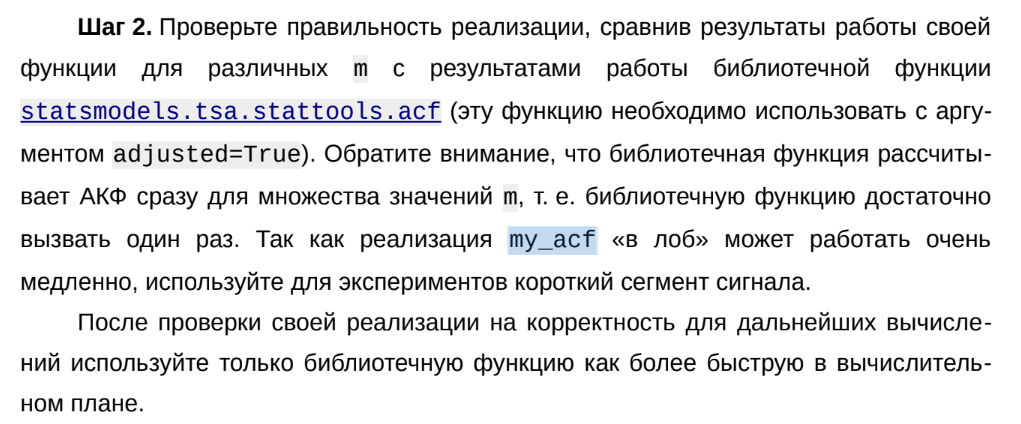

In [ ]:
# Шаг 1: Загрузим аудиофайл
fs, x = wavfile.read('Lab2/input.wav')  # Загрузите свой wav-файл

# Если файл стерео (2 канала), выберем один канал (моно)
if len(x.shape) > 1:
    x = x[:, 0]  # Берем первый канал (можно изменить, если нужно)

# Преобразуем сигнал в тип данных float32 для нормализации
x = x.astype(np.float32)

# Шаг 2: Нормализуем сигнал (опционально, если сигнал имеет большие значения)
x = x / np.max(np.abs(x))  # Нормализация сигнала в диапазон [-1, 1]

# Шаг 3: Вызовем функцию my_acf для вычисления АКФ для некоторого m
m = 100  # Это количество смещений для автокорреляции
acf_value = my_acf(x, m)  # Вызов функции my_acf

# Выведем значение АКФ для заданного m
print(f"Значение АКФ для m={m}: {acf_value}")

#### Step 3 
Постройте график АКФ и оцените по нему частоту основного тона речи.

### 3.3 Оценка основного тона на основе ДВПФ

#### Step 1

In [ ]:
def my_dtft(x, fs,f):


#### Step 2
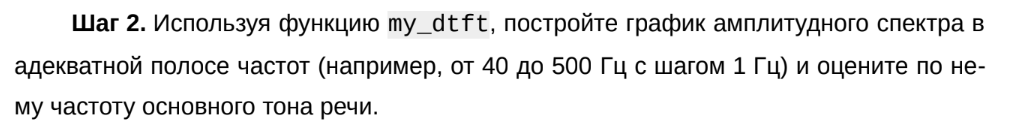

In [ ]:
for f in range(40, 501):
    my_dtft(x,fs,f)

### 3.4 Оценка основного тона с помощью Google REAPER